Total MIMIC II patient records found: 500


Loading MIMIC II Patient Records: 100%|██████████████████████████████████████████████| 500/500 [04:18<00:00,  1.93it/s]


Loaded PPG patient records: 500
Loaded ABP patient records: 500

Applying Adaptive Kalman Filter to PPG and ABP signals...


Filtering ABP signals: 100%|█████████████████████████████████████████████████████████| 500/500 [00:21<00:00, 23.22it/s]



=== Descriptive Statistics for Filtered Signals (Before Automatic Feature Extraction) ===

Descriptive Statistics for PPG (Filtered Signals (Before Automatic Feature Extraction)):
Mean: 1.6420
Standard Deviation: 0.7063
Minimum: 0.0000
Maximum: 4.0020
Median: 1.4659
25th Percentile: 1.1185
75th Percentile: 2.1672

Descriptive Statistics for ABP (Filtered Signals (Before Automatic Feature Extraction)):
Mean: 91.9269
Standard Deviation: 28.0067
Minimum: 50.0669
Maximum: 199.6423
Median: 83.7913
25th Percentile: 70.2419
75th Percentile: 107.9921

Visualizing Sample PPG Signal: Original vs. Filtered


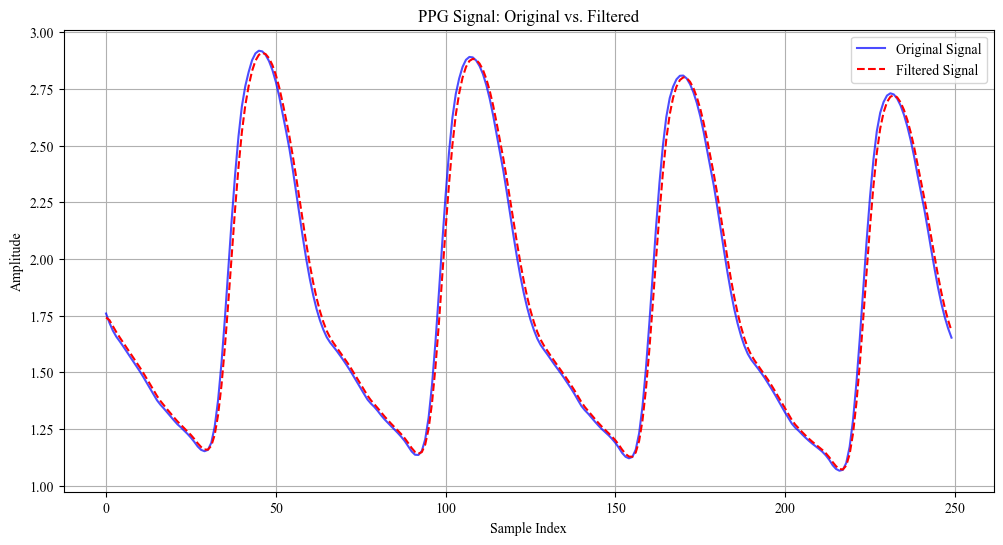


Visualizing ABP Signal: Original vs. Filtered


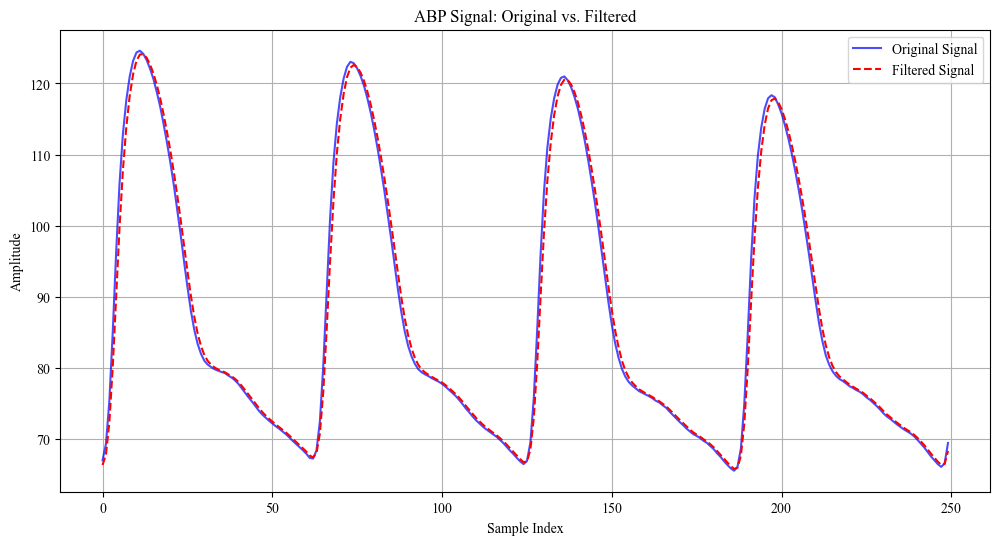


Visualizing Sample Signal Synchronization: Before vs. After


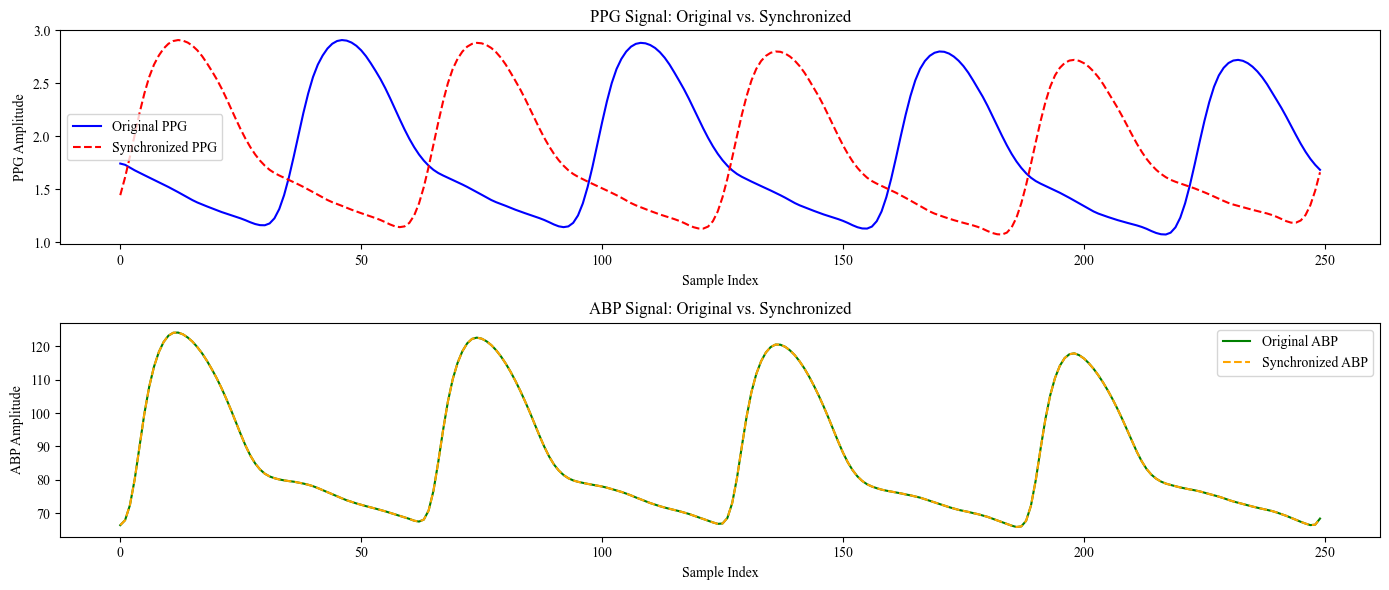


Generating features and targets automatically...


Automatic Feature Extraction:: 100%|█████████████████████████████████████████████████| 500/500 [01:26<00:00,  5.80it/s]


Generated PPG features: 202946
Generated SBP targets: 202946
Generated DBP targets: 202946

=== Descriptive Statistics for After Automatic Feature Extraction ===

Descriptive Statistics for PPG (After Automatic Feature Extraction):
Mean: 1.6420
Standard Deviation: 0.7063
Minimum: 0.0000
Maximum: 4.0020
Median: 1.4659
25th Percentile: 1.1185
75th Percentile: 2.1672

Descriptive Statistics for SBP (After Automatic Feature Extraction):
Mean: 141.3698
Standard Deviation: 21.9636
Minimum: 70.1697
Maximum: 199.6423
Median: 142.1948
25th Percentile: 126.1044
75th Percentile: 157.3981

Descriptive Statistics for DBP (After Automatic Feature Extraction):
Mean: 65.0663
Standard Deviation: 11.5771
Minimum: 0.0000
Maximum: 157.2081
Median: 63.0064
25th Percentile: 57.9700
75th Percentile: 70.2658

Filtering data based on SBP and DBP bounds...

=== Descriptive Statistics for After SBP/DBP Outlier Removal ===

Descriptive Statistics for PPG (After SBP/DBP Outlier Removal):
Mean: 1.6420
Standard Devi

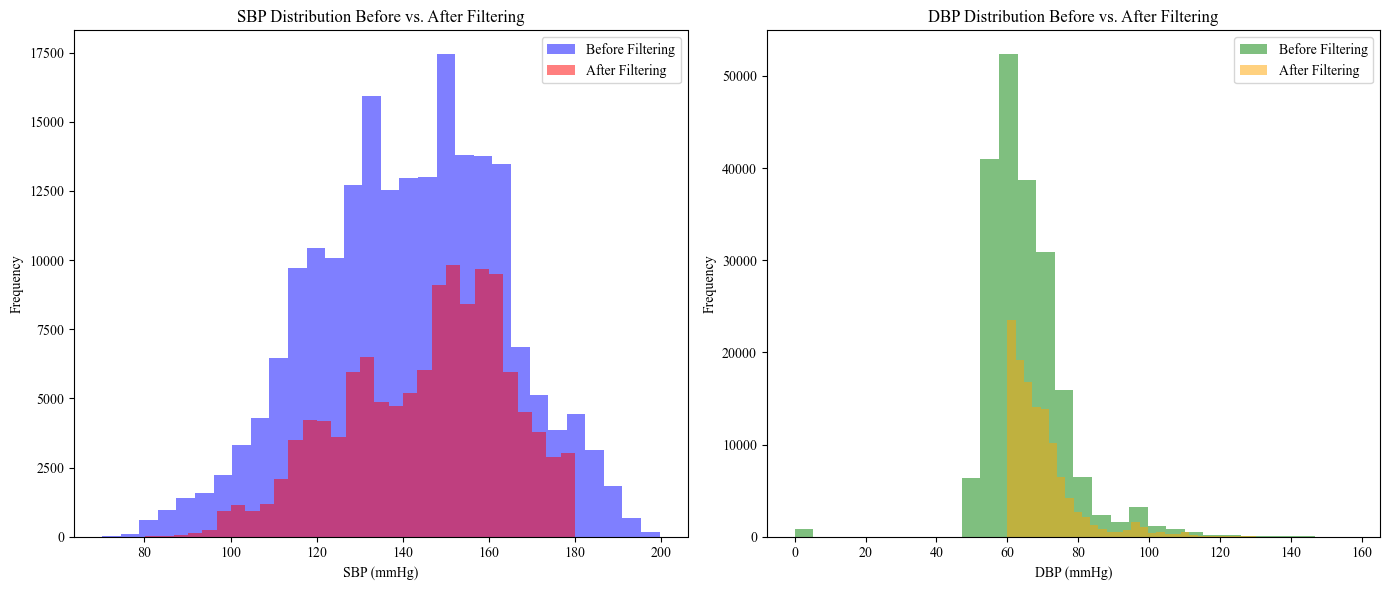

Input Dimension: 750

Training Multi-Task Transformer cBP-Tnet Model:


cBP-Tnet Training Epochs: 100%|█| 1500/1500 [47:21:27<00:00, 113.66s/it, Train Loss=1.8697, Val Loss=3.1259, Time=112.5



Best model loaded from 'cBP-Tnet_Model.pth' saved at epoch 1295 with validation loss 3.1193

=== Validation Set Evaluation Metrics (cBP-Tnet Model) ===
SBP Mean Absolute Error: 4.1351
SBP Correlation Coefficient: 0.894

=== Validation Set DBP Evaluation Metrics (cBP-Tnet Model) ===
DBP Mean Absolute Error: 2.1040
DBP Correlation Coefficient: 0.885

=== Test Set Evaluation Metrics (cBP-Tnet Model) ===
SBP Mean Absolute Error: 4.3185
SBP Correlation Coefficient: 0.885

=== Test Set DBP Evaluation Metrics (cBP-Tnet Model) ===
DBP Mean Absolute Error: 2.1780
DBP Correlation Coefficient: 0.874


----------------SBP (cBP-Tnet Test Set)-----------------

-------------AAMI standard--------------------------------
ME             MAE             SD           total
-0.125         4.318         8.960          12221

-------------BHS standard---------------------------------
<5mmHg        <10mmHg        <15mmHg        total
9722            11004           11455          12221
79.552%        90.042

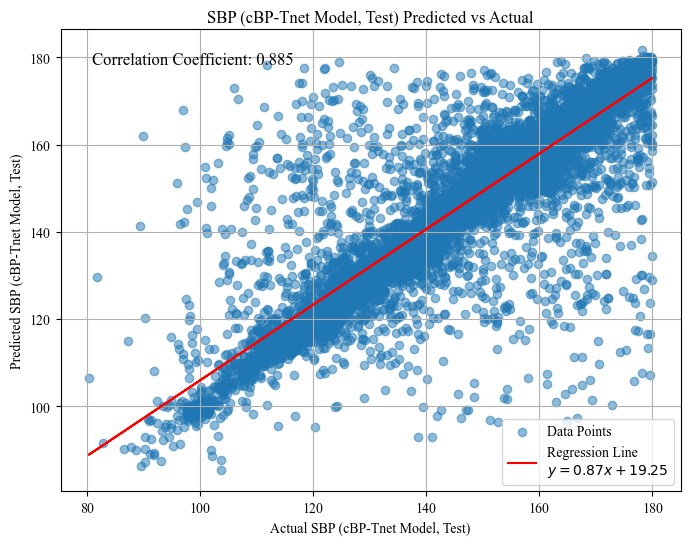

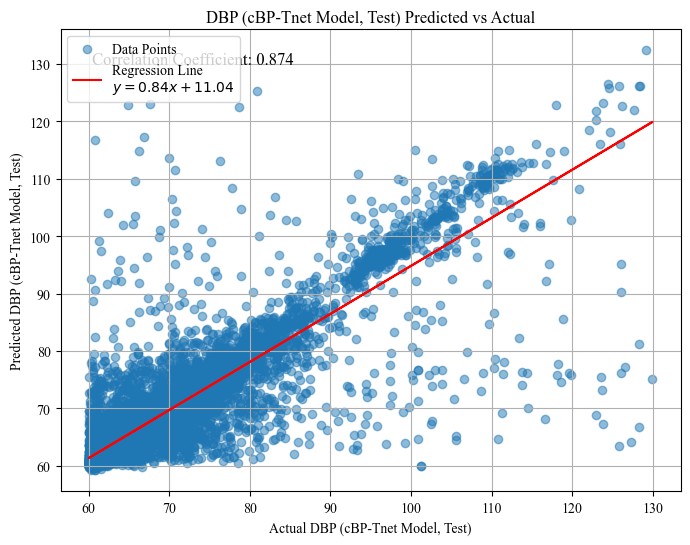

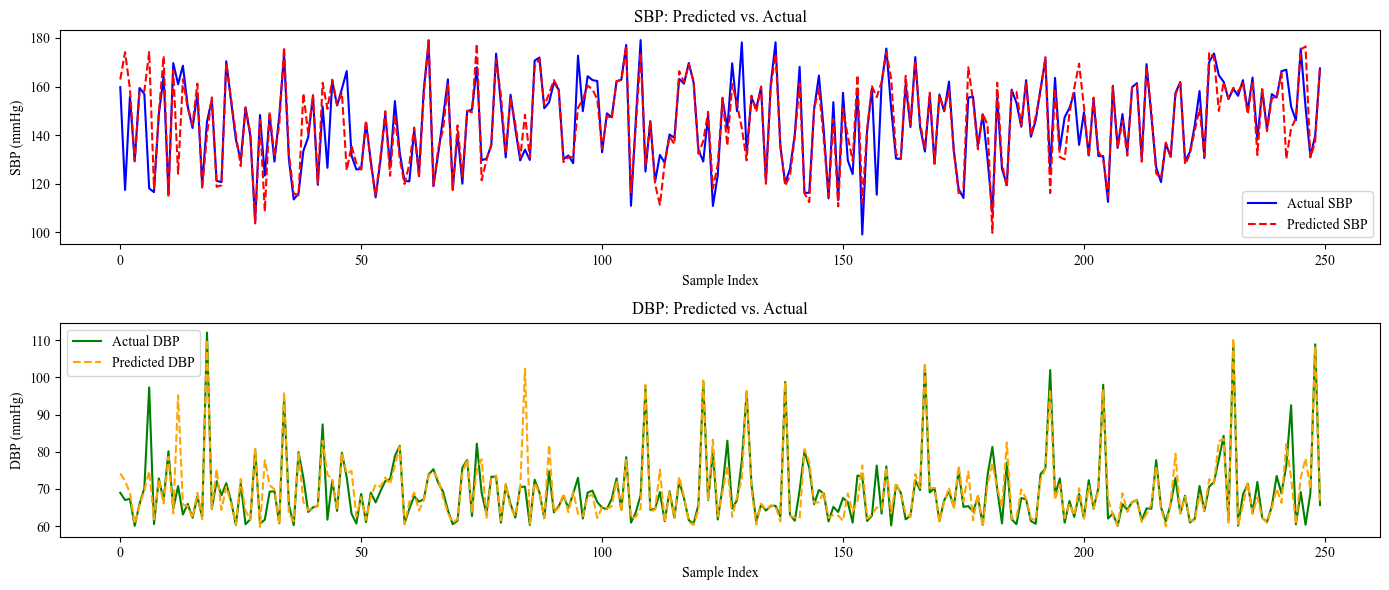

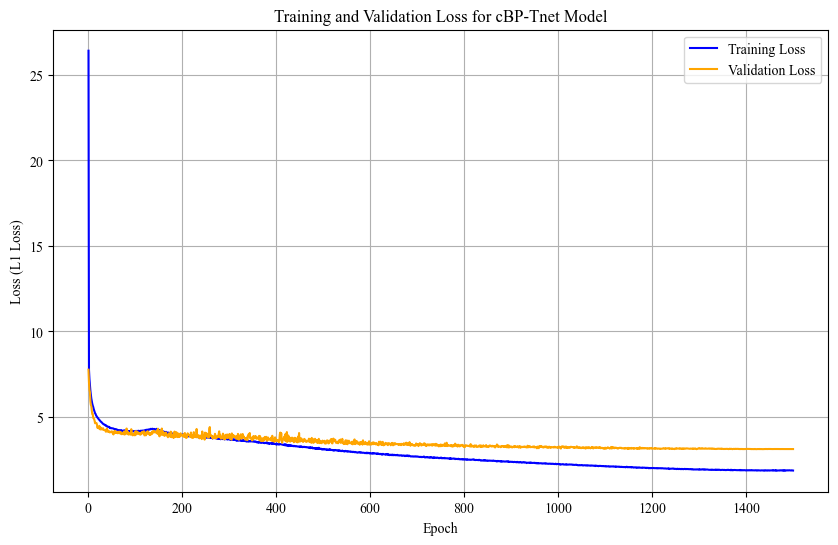


Converting the trained model to TorchScript for cBP-Tnet Edge Model...
Model successfully scripted and saved as 'cBP-Tnet_Edge_Model.pt'.
cBP-Tnet Edge Model is a version of cBP-Tnet model that is readily deployable to Edge Devices (Mobile Phones, Microcontrollers, etc.) for practical usage
Scripted model successfully loaded.

Performing predictions with the scripted (cBP-Tnet Edge Model) on the test set...

=== Test Set Evaluation Metrics (cBP-Tnet Edge Model) ===
SBP Mean Absolute Error: 4.3185
SBP Correlation Coefficient: 0.885
DBP Mean Absolute Error: 2.1780
DBP Correlation Coefficient: 0.874

Generating Visualizations for cBP-Tnet Edge Model...


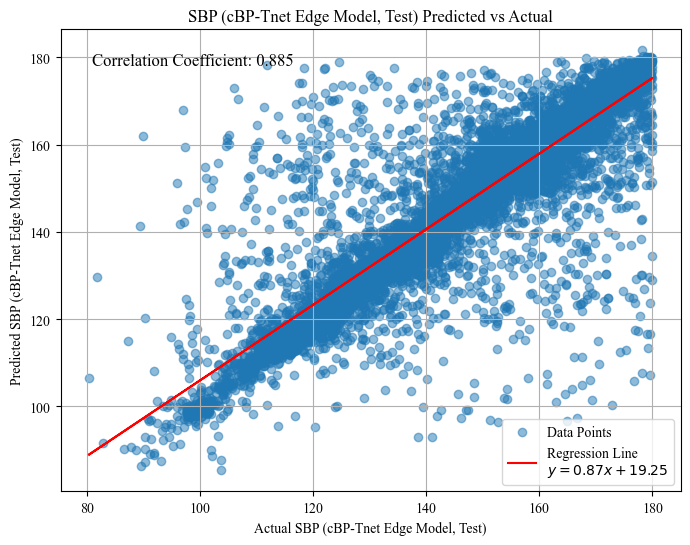

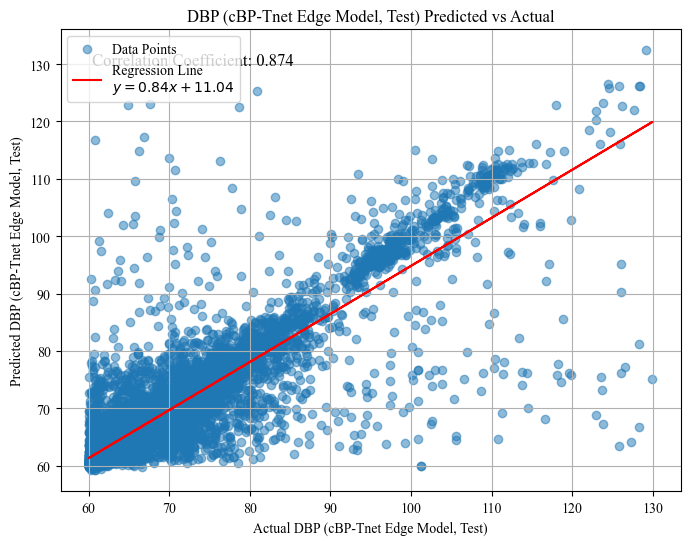

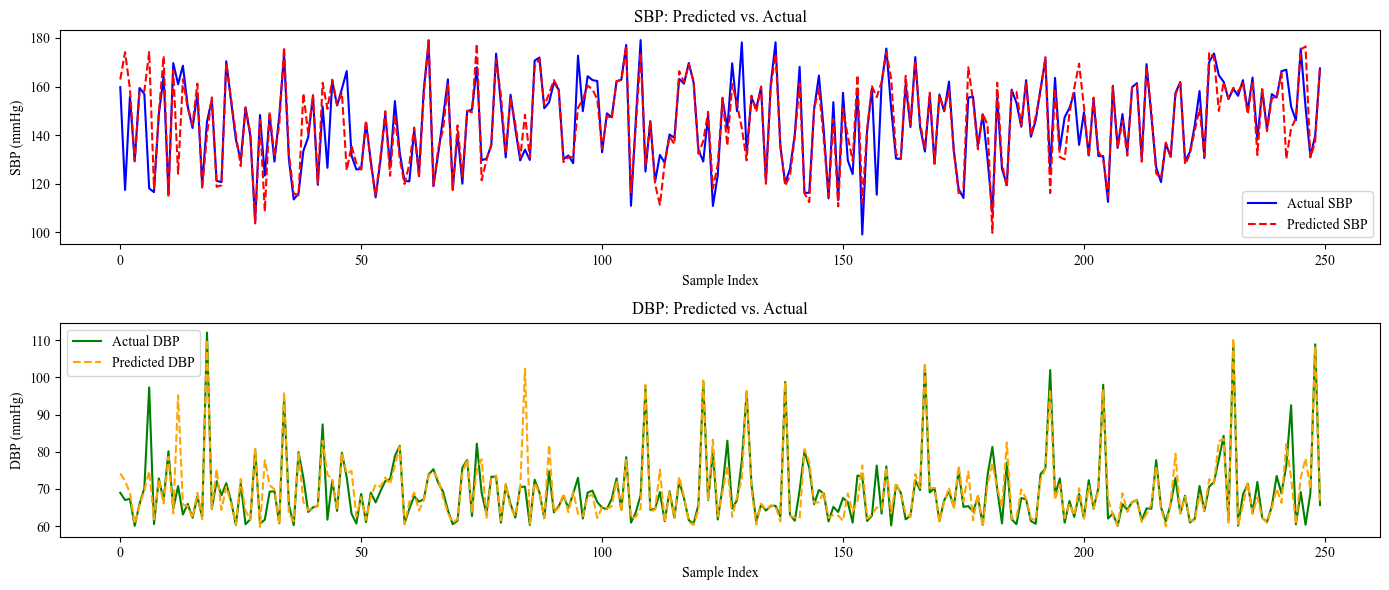



============ cBP-Tnet AI Model Comparison ============
Comparing cBP-Tnet Model with cBP-Tnet Edge Model on Test Set MAE:
              Model  SBP MAE  DBP MAE
     cBP-Tnet Model 4.318483 2.178013
cBP-Tnet Edge Model 4.318483 2.178013


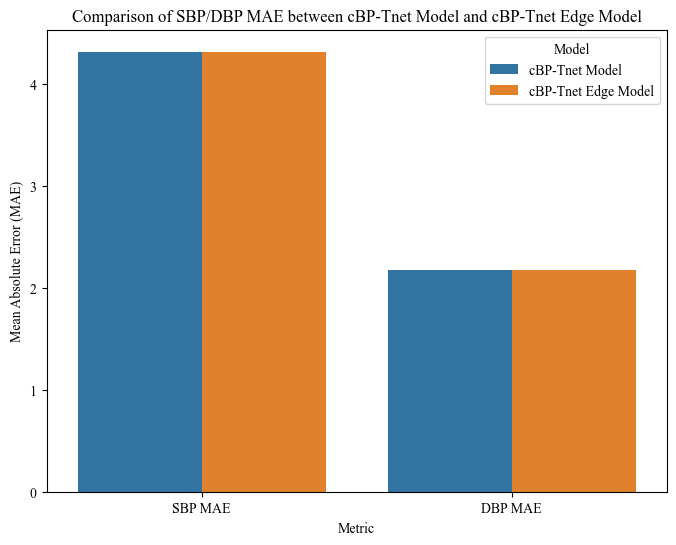

In [1]:
# =====================================
# Module 1: Imports and Configuration
# =====================================

import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import torch.utils.data as Data
import glob
from pyampd.ampd import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR
import time
import warnings
import random
from tqdm import tqdm
from scipy.stats import linregress
import copy
import seaborn as sns

warnings.filterwarnings('ignore')

# Set matplotlib to use Times New Roman font globally
plt.rcParams['font.family'] = 'Times New Roman'

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seeds for reproducibility
def set_random_seeds(seed=125):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# =====================================
# Module 2: Data Handling
# =====================================

def load_dataset(path_pattern='MIMIC_II_BloodPressureDataset/Samples/*.csv'):
    # The cleaned MIMIC II dataset can be downloaded via link below. Only the .csv files (500 patient records) were used.
    # Physionet's MIMIC II Subset Data: https://www.kaggle.com/datasets/mkachuee/BloodPressureDataset
    # UCI Machine Learning Repository: https://archive.ics.uci.edu/dataset/340/cuff+less+blood+pressure+estimation
    PPG_datas = []
    ABP_datas = []
    files = glob.glob(path_pattern)
    print(f"Total MIMIC II patient records found: {len(files)}")
    for i, name in enumerate(tqdm(files, desc="Loading MIMIC II Patient Records")):
        raw_training_data = pd.read_csv(name, header=None).values
        PPG_datas.append(raw_training_data[0].reshape(-1))
        ABP_datas.append(raw_training_data[1].reshape(-1))
    print(f"Loaded PPG patient records: {len(PPG_datas)}")
    print(f"Loaded ABP patient records: {len(ABP_datas)}")
    return np.array(PPG_datas, dtype=object), np.array(ABP_datas, dtype=object)

def generate_fixed_length_vector(signal, length=250):
    if len(signal) < length:
        padded_signal = np.zeros(length)
        padded_signal[:len(signal)] = signal
    else:
        padded_signal = signal[:length]
    return padded_signal

def calculate_derivatives(ppg_signal):
    first_derivative = np.gradient(ppg_signal)
    second_derivative = np.gradient(first_derivative)
    return first_derivative, second_derivative

def adaptive_kalman_filter(signal, initial_state=0, initial_covariance=1, process_variance=1e-5, measurement_variance=1e-2):
    n = len(signal)
    filtered_signal = np.zeros(n)

    # Initialize state and covariance
    x = initial_state
    P = initial_covariance

    for t in range(n):
        # Prediction step
        x_prior = x
        P_prior = P + process_variance

        # Update step
        K = P_prior / (P_prior + measurement_variance)
        x = x_prior + K * (signal[t] - x_prior)
        P = (1 - K) * P_prior

        filtered_signal[t] = x

        # Adapt process_variance and measurement_variance based on residual
        residual = signal[t] - x_prior
        process_variance = 0.99 * process_variance + 0.01 * residual**2
        measurement_variance = 0.99 * measurement_variance + 0.01 * residual**2

    return filtered_signal

def synchronize_signals(PPG_signal, ABP_signal):
    PPG_signal = np.asarray(PPG_signal).flatten()
    ABP_signal = np.asarray(ABP_signal).flatten()
    correlation = np.correlate(ABP_signal - np.mean(ABP_signal), PPG_signal - np.mean(PPG_signal), mode='full')
    lag = correlation.argmax() - (len(PPG_signal) - 1)
    if lag > 0:
        ABP_signal_sync = ABP_signal[lag:]
        PPG_signal_sync = PPG_signal[:len(ABP_signal_sync)]
    elif lag < 0:
        lag = -lag
        PPG_signal_sync = PPG_signal[lag:]
        ABP_signal_sync = ABP_signal[:len(PPG_signal_sync)]
    else:
        ABP_signal_sync = ABP_signal
        PPG_signal_sync = PPG_signal
    return PPG_signal_sync, ABP_signal_sync

def generate_features(PPG_datas, ABP_datas, sample_freq=125, window_size=250):
    whole_based_vectors = []
    SBP_data = []
    DBP_data = []

    for j in tqdm(range(len(PPG_datas)), desc="Automatic Feature Extraction:"):
        PPG_data = PPG_datas[j]
        ABP_data = ABP_datas[j]
        PPG_data_sync, ABP_data_sync = synchronize_signals(PPG_data, ABP_data)
        min_length = min(len(PPG_data_sync), len(ABP_data_sync))
        PPG_data_sync = PPG_data_sync[:min_length]
        ABP_data_sync = ABP_data_sync[:min_length]

        PPG_peaks = find_peaks(PPG_data_sync, scale=sample_freq)
        for i in range(2, PPG_peaks.shape[0]):
            raw_ppg_signal = PPG_data_sync[PPG_peaks[i-1]:PPG_peaks[i]]
            first_derivative, second_derivative = calculate_derivatives(raw_ppg_signal)
            fixed_raw_ppg_signal = generate_fixed_length_vector(raw_ppg_signal, length=window_size)
            fixed_first_derivative = generate_fixed_length_vector(first_derivative, length=window_size)
            fixed_second_derivative = generate_fixed_length_vector(second_derivative, length=window_size)
            whole_based_vector = np.hstack([
                fixed_raw_ppg_signal,
                fixed_first_derivative,
                fixed_second_derivative
            ])
            abp_start = PPG_peaks[i-1]
            abp_end = PPG_peaks[i-1] + window_size
            ABP_segment = ABP_data_sync[abp_start:abp_end]
            padded_ABP_segment = generate_fixed_length_vector(ABP_segment, length=window_size)
            SBP = np.max(padded_ABP_segment)
            DBP = np.min(padded_ABP_segment)
            whole_based_vectors.append(whole_based_vector)
            SBP_data.append(SBP)
            DBP_data.append(DBP)

    print(f"Generated PPG features: {len(whole_based_vectors)}")
    print(f"Generated SBP targets: {len(SBP_data)}")
    print(f"Generated DBP targets: {len(DBP_data)}")
    return np.array(whole_based_vectors), np.array(SBP_data), np.array(DBP_data)

def filter_data(whole_based_vectors, SBP_data, DBP_data,
               SBP_bounds=(80, 180), DBP_bounds=(60, 130)):
    spec_mask = (
        (SBP_data >= SBP_bounds[0]) & (SBP_data <= SBP_bounds[1]) &
        (DBP_data >= DBP_bounds[0]) & (DBP_data <= DBP_bounds[1])
    )
    filtered_vectors = whole_based_vectors[spec_mask]
    filtered_SBP = SBP_data[spec_mask]
    filtered_DBP = DBP_data[spec_mask]

    return filtered_vectors, filtered_SBP, filtered_DBP

# ---------------------------
# Data Augmentation Functions
# ---------------------------

def add_gaussian_noise(signal, mean=0.0, std=0.05):
    noise = np.random.normal(mean, std, signal.shape)
    return signal + noise

def scaling(signal, scale_factor=0.1):
    factor = 1 + np.random.uniform(-scale_factor, scale_factor)
    return signal * factor

def shifting(signal, max_shift=10):
    shift = np.random.randint(-max_shift, max_shift)
    if shift > 0:
        return np.pad(signal, (shift, 0), mode='constant')[:len(signal)]
    elif shift < 0:
        return np.pad(signal, (0, -shift), mode='constant')[-shift:]
    else:
        return signal

def random_masking(signal, mask_size=10):
    start = np.random.randint(0, len(signal) - mask_size)
    signal[start:start + mask_size] = 0
    return signal

# ---------------------------
# Custom Dataset Class
# ---------------------------

from torch.utils.data import Dataset

class BloodPressureDataset(Dataset):
    def __init__(self, X, y_sbp, y_dbp, augment=False):
        self.X = X
        self.y_sbp = y_sbp
        self.y_dbp = y_dbp
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        signal = self.X[idx].copy()  

        if self.augment:
            # Apply random augmentations
            if random.random() < 0.5:
                signal = add_gaussian_noise(signal)
            if random.random() < 0.5:
                signal = scaling(signal)
            if random.random() < 0.3:
                signal = shifting(signal)
            if random.random() < 0.3:
                signal = random_masking(signal)

        sbp_target = self.y_sbp[idx]
        dbp_target = self.y_dbp[idx]
        targets = np.array([sbp_target, dbp_target], dtype=np.float32)
        return torch.from_numpy(signal).float(), torch.from_numpy(targets).float()

# =====================================
# Module 3: Descriptive Statistics
# =====================================

def compute_descriptive_statistics(PPG_datas_filtered, ABP_datas_filtered, SBP_data=None, DBP_data=None, dataset_name=''):
    """
    Computes and prints descriptive statistics for PPG, ABP, SBP, and DBP datasets.
    """
    print(f"\n=== Descriptive Statistics for {dataset_name} ===")
    
    # Compute statistics for PPG
    all_PPG = np.concatenate(PPG_datas_filtered)
    PPG_stats = {
        'Mean': np.mean(all_PPG),
        'Standard Deviation': np.std(all_PPG),
        'Minimum': np.min(all_PPG),
        'Maximum': np.max(all_PPG),
        'Median': np.median(all_PPG),
        '25th Percentile': np.percentile(all_PPG, 25),
        '75th Percentile': np.percentile(all_PPG, 75)
    }
    print(f"\nDescriptive Statistics for PPG ({dataset_name}):")
    for key, value in PPG_stats.items():
        print(f"{key}: {value:.4f}")

    if dataset_name not in ['After Automatic Feature Extraction', 'After SBP/DBP Outlier Removal']:
        # Compute statistics for ABP
        all_ABP = np.concatenate(ABP_datas_filtered)
        ABP_stats = {
            'Mean': np.mean(all_ABP),
            'Standard Deviation': np.std(all_ABP),
            'Minimum': np.min(all_ABP),
            'Maximum': np.max(all_ABP),
            'Median': np.median(all_ABP),
            '25th Percentile': np.percentile(all_ABP, 25),
            '75th Percentile': np.percentile(all_ABP, 75)
        }
        print(f"\nDescriptive Statistics for ABP ({dataset_name}):")
        for key, value in ABP_stats.items():
            print(f"{key}: {value:.4f}")

    if SBP_data is not None and DBP_data is not None:
        # Compute statistics for SBP
        SBP_stats = {
            'Mean': np.mean(SBP_data),
            'Standard Deviation': np.std(SBP_data),
            'Minimum': np.min(SBP_data),
            'Maximum': np.max(SBP_data),
            'Median': np.median(SBP_data),
            '25th Percentile': np.percentile(SBP_data, 25),
            '75th Percentile': np.percentile(SBP_data, 75)
        }
        print(f"\nDescriptive Statistics for SBP ({dataset_name}):")
        for key, value in SBP_stats.items():
            print(f"{key}: {value:.4f}")
        
        # Compute statistics for DBP
        DBP_stats = {
            'Mean': np.mean(DBP_data),
            'Standard Deviation': np.std(DBP_data),
            'Minimum': np.min(DBP_data),
            'Maximum': np.max(DBP_data),
            'Median': np.median(DBP_data),
            '25th Percentile': np.percentile(DBP_data, 25),
            '75th Percentile': np.percentile(DBP_data, 75)
        }
        print(f"\nDescriptive Statistics for DBP ({dataset_name}):")
        for key, value in DBP_stats.items():
            print(f"{key}: {value:.4f}")

# =====================================
# Module 4: Model Definition
# =====================================

class TransformerModel(nn.Module):
    """
    cBP-Tnet Transformer-based neural network model with multi-task learning (SBP and DBP).
    """
    def __init__(self, input_dim, model_dim=128, num_heads=4, num_layers=8, output_dim=2, dropout=0.05):
        super(TransformerModel, self).__init__()
        self.input_projection = nn.Linear(input_dim, model_dim)
        self.positional_encoding = nn.Parameter(torch.randn(1, model_dim), requires_grad=True)
        
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
            for _ in range(num_layers)
        ])
        self.layer_norm = nn.LayerNorm(model_dim)
        self.output_layer = nn.Linear(model_dim, output_dim)
    
    def forward(self, x):
        """
        Forward pass of the Multi-task Transformer Model.
        """
        if x.dim() == 2:
            x = x.unsqueeze(1)  
        
        x = self.input_projection(x) + self.positional_encoding  # Shape: (batch_size, sequence_length, model_dim)
        
        for encoder_layer in self.encoder_layers:
            residual = x
            x = encoder_layer(x)
            x = self.layer_norm(x + residual)  # Residual connection + Layer Normalization

        # Global Max Pooling
        x, _ = x.max(dim=1)  # Shape: (batch_size, model_dim)
        
        x = self.output_layer(x)  # Shape: (batch_size, output_dim)
        return x

# =====================================
# Module 5: Training Utilities
# =====================================

class Trainer:
    """
    cBP-Tnet Trainer class for handling the training and validation of models.
    """
    def __init__(self, model, train_loader, val_loader, epochs, lr, max_lr=None, save_path='cBP-Tnet_Model.pth'):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epochs = epochs
        self.lr = lr
        self.save_path = save_path
        self.device = DEVICE
        self.model.to(self.device)
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        
        self.scheduler = OneCycleLR(
            self.optimizer,
            max_lr=max_lr if max_lr else 10 * lr,
            steps_per_epoch=len(train_loader),
            epochs=epochs
        )

        self.criterion = nn.L1Loss()

        # Initialize best validation loss and epoch
        self.best_val_loss = float('inf')
        self.best_epoch = 0

        # Loss storage
        self.train_losses = []
        self.val_losses = []
        self.epoch_times = []

    def train_model(self, grad_clip=4.0):
        epoch_iter = tqdm(range(self.epochs), desc="cBP-Tnet Training Epochs")
        for epoch in epoch_iter:
            start_time = time.time()
            self.model.train()
            total_train_loss = 0
            for batch_X, batch_y in self.train_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), grad_clip)

                self.optimizer.step()
                self.scheduler.step()
                total_train_loss += loss.item()
            
            avg_train_loss = total_train_loss / len(self.train_loader)
            avg_val_loss = self.validate()

            # Record losses and time
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            epoch_time = time.time() - start_time
            self.epoch_times.append(epoch_time)

            epoch_iter.set_postfix({
                'Train Loss': f"{avg_train_loss:.4f}",
                'Val Loss': f"{avg_val_loss:.4f}",
                'Time': f"{epoch_time:.2f}s"
            })

            # Check for improvement
            if avg_val_loss < self.best_val_loss:
                self.best_val_loss = avg_val_loss
                self.best_epoch = epoch + 1 
                torch.save(self.model.state_dict(), self.save_path)

    def validate(self):
        self.model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in self.val_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(self.val_loader)
        return avg_val_loss

def predict(model, data_loader, device):
    model.eval()
    sbp_predictions = []
    dbp_predictions = []
    with torch.no_grad():
        for batch_X, _ in data_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            outputs = outputs.cpu().numpy()
            sbp_predictions.extend(outputs[:, 0])
            dbp_predictions.extend(outputs[:, 1])
    return np.array(sbp_predictions), np.array(dbp_predictions)

# =====================================
# Module 6: Evaluation Metrics
# =====================================

def calculate_metrics(predictions, targets):
    mae = np.mean(np.abs(predictions - targets))
    cc = np.corrcoef(predictions, targets)[0, 1]
    return mae, cc

# --- AAMI and BHS Evaluation Functions ---

def AAMI_standard(predict, test):
    total = len(predict)
    ME = np.mean(predict - test)
    MAE = np.mean(np.abs(predict - test))
    SD = np.std(predict - test)
    
    return total, ME, MAE, SD
    
def BHS_standard(predict, test):
    total = len(predict)
    mm5 = np.sum(np.abs(predict - test) <= 5)
    mm10 = np.sum(np.abs(predict - test) <= 10)
    mm15 = np.sum(np.abs(predict - test) <= 15)
    return total, mm5, mm10, mm15

# =====================================
# Module 7: Visualization
# =====================================

def plot_predicted_vs_actual(SBP_predictions, SBP_actual, DBP_predictions, DBP_actual, window_size=250):
    window_size = min(window_size, len(SBP_actual))
    indices = np.arange(window_size)
    
    plt.figure(figsize=(14, 6))

    # Plot SBP
    plt.subplot(2, 1, 1)
    plt.plot(indices, SBP_actual[:window_size], label='Actual SBP', color='blue')
    plt.plot(indices, SBP_predictions[:window_size], label='Predicted SBP', color='red', linestyle='--')
    plt.title('SBP: Predicted vs. Actual')
    plt.xlabel('Sample Index')
    plt.ylabel('SBP (mmHg)')
    plt.legend()

    # Plot DBP
    plt.subplot(2, 1, 2)
    plt.plot(indices, DBP_actual[:window_size], label='Actual DBP', color='green')
    plt.plot(indices, DBP_predictions[:window_size], label='Predicted DBP', color='orange', linestyle='--')
    plt.title('DBP: Predicted vs. Actual')
    plt.xlabel('Sample Index')
    plt.ylabel('DBP (mmHg)')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_train_val_loss(trainer, label='cBP-Tnet Model'):
    epochs = range(1, len(trainer.train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, trainer.train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, trainer.val_losses, label='Validation Loss', color='orange')
    plt.title(f'Training and Validation Loss for {label}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (L1 Loss)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_signal_comparison(original_signal, filtered_signal, window_size=250, title='Signal Comparison'):
    """
    Plots original and filtered signals for comparison.
    """
    window_size = min(window_size, len(original_signal), len(filtered_signal))
    indices = np.arange(window_size)

    plt.figure(figsize=(12, 6))
    plt.plot(indices, original_signal[:window_size], label='Original Signal', color='blue', alpha=0.7)
    plt.plot(indices, filtered_signal[:window_size], label='Filtered Signal', color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_sync_comparison(ppg_original, abp_original, ppg_sync, abp_sync, window_size=250):
    """
    Plots original and synchronized PPG and ABP signals for comparison.
    """
    window_size = min(window_size, len(ppg_original), len(abp_original), len(ppg_sync), len(abp_sync))
    indices = np.arange(window_size)

    plt.figure(figsize=(14, 6))

    # Plot PPG
    plt.subplot(2, 1, 1)
    plt.plot(indices, ppg_original[:window_size], label='Original PPG', color='blue')
    plt.plot(indices, ppg_sync[:window_size], label='Synchronized PPG', color='red', linestyle='--')
    plt.title('PPG Signal: Original vs. Synchronized')
    plt.xlabel('Sample Index')
    plt.ylabel('PPG Amplitude')
    plt.legend()

    # Plot ABP
    plt.subplot(2, 1, 2)
    plt.plot(indices, abp_original[:window_size], label='Original ABP', color='green')
    plt.plot(indices, abp_sync[:window_size], label='Synchronized ABP', color='orange', linestyle='--')
    plt.title('ABP Signal: Original vs. Synchronized')
    plt.xlabel('Sample Index')
    plt.ylabel('ABP Amplitude')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_overlapping_histograms(SBP_before, SBP_after, DBP_before, DBP_after, bins=30):
    """
    Plots overlapping histograms of SBP and DBP before and after filtering.
    """
    # SBP Overlapping Histogram
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.hist(SBP_before, bins=bins, color='blue', alpha=0.5, label='Before Filtering')
    plt.hist(SBP_after, bins=bins, color='red', alpha=0.5, label='After Filtering')
    plt.title('SBP Distribution Before vs. After Filtering')
    plt.xlabel('SBP (mmHg)')
    plt.ylabel('Frequency')
    plt.legend()

    # DBP Overlapping Histogram
    plt.subplot(1, 2, 2)
    plt.hist(DBP_before, bins=bins, color='green', alpha=0.5, label='Before Filtering')
    plt.hist(DBP_after, bins=bins, color='orange', alpha=0.5, label='After Filtering')
    plt.title('DBP Distribution Before vs. After Filtering')
    plt.xlabel('DBP (mmHg)')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- Scatter Plot with Regression Line and Equation ---

def plot_scatter_with_regression(predictions, actuals, bp_type='SBP'):
    """
    Plots scatter plot of Predicted vs Actual values with regression line, correlation coefficient, and equation.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(actuals, predictions, alpha=0.5, label='Data Points')

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(actuals, predictions)
    regression_line = slope * actuals + intercept
    plt.plot(actuals, regression_line, color='red', label=f'Regression Line\n$y={slope:.2f}x+{intercept:.2f}$')

    # Calculate correlation coefficient
    plt.title(f'{bp_type} Predicted vs Actual')
    plt.xlabel(f'Actual {bp_type}')
    plt.ylabel(f'Predicted {bp_type}')
    plt.legend()

    # Annotate with correlation coefficient
    plt.text(0.05, 0.95, f'Correlation Coefficient: {r_value:.3f}',
             transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top')

    plt.grid(True)
    plt.show()

# =====================================
# Module 8: Main Execution
# =====================================

def main():
    """
    Main function for data loading, training, evaluation, conversion to cBP-Tnet Edge Model, and comparative analysis.
    """
    # Configuration Parameters
    SAMPLE_FREQ = 125
    EPOCHS = 1500  
    LR = 0.001
    WINDOW_SIZE = 2 * SAMPLE_FREQ  # 2 seconds (250 samples)
    NUM_BINS = 10  
    PLOT_WINDOW_SIZE = 250  # Number of samples to plot in Predicted vs Actual

    # Set random seeds
    set_random_seeds(125)
    
    # Load dataset
    PPG_datas, ABP_datas = load_dataset()
    
    # Apply Adaptive Kalman Filter to PPG and ABP signals
    print("\nApplying Adaptive Kalman Filter to PPG and ABP signals...")
    PPG_datas_filtered = []
    ABP_datas_filtered = []
    for ppg in tqdm(PPG_datas, desc="Filtering PPG signals"):
        filtered_ppg = adaptive_kalman_filter(ppg)
        PPG_datas_filtered.append(filtered_ppg)
    for abp in tqdm(ABP_datas, desc="Filtering ABP signals"):
        filtered_abp = adaptive_kalman_filter(abp)
        ABP_datas_filtered.append(filtered_abp)
    
    # Compute and display descriptive statistics before automatic feature extraction
    compute_descriptive_statistics(
        PPG_datas_filtered=PPG_datas_filtered,
        ABP_datas_filtered=ABP_datas_filtered,
        dataset_name='Filtered Signals (Before Automatic Feature Extraction)'
    )
    
    # Visualize a sample before and after filtering
    sample_index = 0  # Change as needed
    print("\nVisualizing Sample PPG Signal: Original vs. Filtered")
    plot_signal_comparison(
        original_signal=PPG_datas[sample_index],
        filtered_signal=PPG_datas_filtered[sample_index],
        window_size=PLOT_WINDOW_SIZE,
        title='PPG Signal: Original vs. Filtered'
    )
    print("\nVisualizing ABP Signal: Original vs. Filtered")
    plot_signal_comparison(
        original_signal=ABP_datas[sample_index],
        filtered_signal=ABP_datas_filtered[sample_index],
        window_size=PLOT_WINDOW_SIZE,
        title='ABP Signal: Original vs. Filtered'
    )
    
    # Visualize synchronization for a sample
    print("\nVisualizing Sample Signal Synchronization: Before vs. After")
    ppg_filtered_sample = PPG_datas_filtered[sample_index]
    abp_filtered_sample = ABP_datas_filtered[sample_index]
    ppg_sync_sample, abp_sync_sample = synchronize_signals(ppg_filtered_sample, abp_filtered_sample)
    plot_sync_comparison(
        ppg_original=ppg_filtered_sample,
        abp_original=abp_filtered_sample,
        ppg_sync=ppg_sync_sample,
        abp_sync=abp_sync_sample,
        window_size=PLOT_WINDOW_SIZE
    )
    
    # Generate features and targets using filtered data
    print("\nGenerating features and targets automatically...")
    whole_based_vectors, SBP_data, DBP_data = generate_features(
        PPG_datas_filtered, ABP_datas_filtered, sample_freq=SAMPLE_FREQ, window_size=WINDOW_SIZE
    )
    
    # Compute and display descriptive statistics after automatic feature extraction
    compute_descriptive_statistics(
        PPG_datas_filtered=PPG_datas_filtered,
        ABP_datas_filtered=ABP_datas_filtered,
        SBP_data=SBP_data,
        DBP_data=DBP_data,
        dataset_name='After Automatic Feature Extraction'
    )
    
    # Filter data based on specifications
    print("\nFiltering data based on SBP and DBP bounds...")
    filtered_vectors, filtered_SBP, filtered_DBP = filter_data(
        whole_based_vectors, SBP_data, DBP_data,
        SBP_bounds=(80, 180), DBP_bounds=(60, 130)
    )
    
    # Add Descriptive Statistics After SBP/DBP Outlier Removal
    compute_descriptive_statistics(
        PPG_datas_filtered=PPG_datas_filtered,  
        ABP_datas_filtered=ABP_datas_filtered,  
        SBP_data=filtered_SBP,
        DBP_data=filtered_DBP,
        dataset_name='After SBP/DBP Outlier Removal'
    )
    
    # Plot overlapping histograms before and after filtering
    print("\nVisualizing Overlapping Histograms for SBP and DBP Before and After Filtering...")
    plot_overlapping_histograms(
        SBP_before=SBP_data,
        SBP_after=filtered_SBP,
        DBP_before=DBP_data,
        DBP_after=filtered_DBP,
        bins=30
    )
    
    # Stratified Train-Validation-Test Split
    X = filtered_vectors
    y_SBP = filtered_SBP
    y_DBP = filtered_DBP

    # Create pandas DataFrame for easier handling
    df = pd.DataFrame({
        'SBP': y_SBP,
        'DBP': y_DBP
    })

    # Bin SBP and DBP into quantiles
    df['SBP_bin'] = pd.qcut(df['SBP'], q=NUM_BINS, duplicates='drop', labels=False)
    df['DBP_bin'] = pd.qcut(df['DBP'], q=NUM_BINS, duplicates='drop', labels=False)

    # Combine SBP_bin and DBP_bin to create a stratification label
    df['stratify_label'] = df['SBP_bin'].astype(str) + "_" + df['DBP_bin'].astype(str)

    # Extract stratification labels
    stratify_labels = df['stratify_label'].values

    # First Split: Train (80%) and Temp (20%)
    X_train, X_temp, SBP_train, SBP_temp, DBP_train, DBP_temp, stratify_train, stratify_temp = train_test_split(
        X, y_SBP, y_DBP, stratify_labels, test_size=0.2, random_state=125, stratify=stratify_labels
    )
    
    # Second Split: Validation (10%) and Test (10%) from Temp (20%)
    X_val, X_test, SBP_val, SBP_test, DBP_val, DBP_test = train_test_split(
        X_temp, SBP_temp, DBP_temp, test_size=0.5, random_state=125, stratify=stratify_temp
    )
    
    # Normalization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    input_dim = X_train_scaled.shape[1]
    print("Input Dimension:", input_dim)
    
    # Prepare Datasets with Augmentation for Training and without for Validation and Test
    train_dataset = BloodPressureDataset(X_train_scaled, SBP_train, DBP_train, augment=True)
    val_dataset = BloodPressureDataset(X_val_scaled, SBP_val, DBP_val, augment=False)
    test_dataset = BloodPressureDataset(X_test_scaled, SBP_test, DBP_test, augment=False)

    # ---------------------------
    # Visualization: Data Augmentation
    # ---------------------------
    # Select a sample from the training set
    sample_index_aug = 250 
    if len(X_train_scaled) > sample_index_aug:
        sample_signal_scaled = X_train_scaled[sample_index_aug]
        sample_signal = scaler.inverse_transform([sample_signal_scaled])[0]  
    else:
        sample_signal_scaled = X_train_scaled[-1]
        sample_signal = scaler.inverse_transform([sample_signal_scaled])[0]

    # Apply Gaussian Noise
    gaussian_augmented = add_gaussian_noise(sample_signal, mean=0.0, std=0.05)

    # Apply Scaling
    scaled_augmented = scaling(sample_signal, scale_factor=0.1)

    # Apply Shifting
    shifted_augmented = shifting(sample_signal, max_shift=10)

    # Apply Random Masking
    masked_augmented = random_masking(sample_signal.copy(), mask_size=10)

    # ---------------------------
    # Prepare DataLoaders
    # ---------------------------
    train_loader = Data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = Data.DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = Data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Instantiate Model
    model = TransformerModel(input_dim=input_dim, output_dim=2)
    
    # Instantiate Trainer with Model Saving
    trainer = Trainer(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, save_path='cBP-Tnet_Model.pth')
    
    # Train Model
    print("\nTraining Multi-Task Transformer cBP-Tnet Model:")
    trainer.train_model(grad_clip=4.0)
    
    # After Training, load the best model
    model.load_state_dict(torch.load('cBP-Tnet_Model.pth'))
    print(f"\nBest model loaded from 'cBP-Tnet_Model.pth' saved at epoch {trainer.best_epoch} with validation loss {trainer.best_val_loss:.4f}")
    
    # Prepare DataLoader for Validation and Test Prediction
    val_loader_for_pred = Data.DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader_for_pred = Data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Predict on Validation Set
    SBP_val_predictions, DBP_val_predictions = predict(trainer.model, val_loader_for_pred, trainer.device)
    
    # Predict on Test Set
    SBP_test_predictions, DBP_test_predictions = predict(trainer.model, test_loader_for_pred, trainer.device)
    
    # Calculate Metrics for Validation Set
    SBP_val_mae, SBP_val_cc = calculate_metrics(SBP_val_predictions, SBP_val)
    DBP_val_mae, DBP_val_cc = calculate_metrics(DBP_val_predictions, DBP_val)
    
    print("\n=== Validation Set Evaluation Metrics (cBP-Tnet Model) ===")
    print(f"SBP Mean Absolute Error: {SBP_val_mae:.4f}")
    print(f"SBP Correlation Coefficient: {SBP_val_cc:.3f}")
    
    print("\n=== Validation Set DBP Evaluation Metrics (cBP-Tnet Model) ===")
    print(f"DBP Mean Absolute Error: {DBP_val_mae:.4f}")
    print(f"DBP Correlation Coefficient: {DBP_val_cc:.3f}")
    
    # Calculate Metrics for Test Set
    SBP_test_mae, SBP_test_cc = calculate_metrics(SBP_test_predictions, SBP_test)
    DBP_test_mae, DBP_test_cc = calculate_metrics(DBP_test_predictions, DBP_test)
    
    print("\n=== Test Set Evaluation Metrics (cBP-Tnet Model) ===")
    print(f"SBP Mean Absolute Error: {SBP_test_mae:.4f}")
    print(f"SBP Correlation Coefficient: {SBP_test_cc:.3f}")
    
    print("\n=== Test Set DBP Evaluation Metrics (cBP-Tnet Model) ===")
    print(f"DBP Mean Absolute Error: {DBP_test_mae:.4f}")
    print(f"DBP Correlation Coefficient: {DBP_test_cc:.3f}")
    
    # --- AAMI and BHS Evaluation ---
    
    print("\n\n----------------SBP (cBP-Tnet Test Set)-----------------")
    print("\n-------------AAMI standard--------------------------------")
    total_SBP_AAMI_test, ME_SBP_test, MAE_SBP_test, SD_SBP_test = AAMI_standard(SBP_test_predictions, SBP_test)
    print('ME             MAE             SD           total')
    print('%.3f         %.3f         %.3f          %d' % (ME_SBP_test, MAE_SBP_test, SD_SBP_test, total_SBP_AAMI_test))
    
    total_SBP_BHS_test, mm5_SBP_test, mm10_SBP_test, mm15_SBP_test = BHS_standard(SBP_test_predictions, SBP_test)
    print("\n-------------BHS standard---------------------------------")
    print('<5mmHg        <10mmHg        <15mmHg        total')
    print('%d            %d           %d          %d' % (mm5_SBP_test, mm10_SBP_test, mm15_SBP_test, total_SBP_BHS_test))
    print('%.3f%s        %.3f%s       %.3f%s         %d' % (
        mm5_SBP_test/total_SBP_BHS_test*100, '%',
        mm10_SBP_test/total_SBP_BHS_test*100, '%',
        mm15_SBP_test/total_SBP_BHS_test*100, '%',
        total_SBP_BHS_test
    ))
    
    print("\n\n----------------DBP (cBP-Tnet Test Set)-----------------")
    print("\n-------------AAMI standard--------------------------------")
    total_DBP_AAMI_test, ME_DBP_test, MAE_DBP_test, SD_DBP_test = AAMI_standard(DBP_test_predictions, DBP_test)
    print('ME             MAE             SD           total')
    print('%.3f         %.3f         %.3f          %d' % (ME_DBP_test, MAE_DBP_test, SD_DBP_test, total_DBP_AAMI_test))
    
    total_DBP_BHS_test, mm5_DBP_test, mm10_DBP_test, mm15_DBP_test = BHS_standard(DBP_test_predictions, DBP_test)
    print("\n-------------BHS standard---------------------------------")
    print('<5mmHg        <10mmHg        <15mmHg        total')
    print('%d            %d           %d          %d' % (mm5_DBP_test, mm10_DBP_test, mm15_DBP_test, total_DBP_BHS_test))
    print('%.3f%s        %.3f%s       %.3f%s         %d' % (
        mm5_DBP_test/total_DBP_BHS_test*100, '%',
        mm10_DBP_test/total_DBP_BHS_test*100, '%',
        mm15_DBP_test/total_DBP_BHS_test*100, '%',
        total_DBP_BHS_test
    ))
    
    # ---------------------------
    # Visualization: Scatter Plots with Regression
    # ---------------------------
    
    print("\nGenerating Scatter Plots with Regression Lines...")
    plot_scatter_with_regression(SBP_test_predictions, SBP_test, bp_type='SBP (cBP-Tnet Model, Test)')
    plot_scatter_with_regression(DBP_test_predictions, DBP_test, bp_type='DBP (cBP-Tnet Model, Test)')
    
    # ---------------------------
    # Visualize Predicted vs Actual
    # ---------------------------
    
    plot_predicted_vs_actual(SBP_test_predictions, SBP_test, DBP_test_predictions, DBP_test, window_size=PLOT_WINDOW_SIZE)
    
    # ---------------------------
    # Visualize Training and Validation Loss
    # ---------------------------
    plot_train_val_loss(trainer, label='cBP-Tnet Model')
    
    # =====================================
    # Conversion to cBP-Tnet Edge Model (TorchScript)
    #
    # "cBP-Tnet Edge Model" is a version of cBP-Tnet model that is readily deployable  
    # to Edge Devices (Mobile Phones, Microcontrollers, etc.) for practical usage
    # =====================================
    
    print("\nConverting the trained model to TorchScript for cBP-Tnet Edge Model...")
    
    # Set the model to evaluation mode
    model.eval()
    
    # Example input for scripting
    example_input = torch.randn(1, input_dim).to(trainer.device)
    
    # Convert the model to TorchScript using scripting
    try:
        scripted_model = torch.jit.script(model)
        scripted_model.save("cBP-Tnet_Edge_Model.pt")
        print("Model successfully scripted and saved as 'cBP-Tnet_Edge_Model.pt'.")
        print("cBP-Tnet Edge Model is a version of cBP-Tnet model that is readily deployable to Edge Devices (Mobile Phones, Microcontrollers, etc.) for practical usage")
    except Exception as e:
        print("Error scripting the model:", e)
        return
    
    # Load the scripted model
    try:
        scripted_model_loaded = torch.jit.load("cBP-Tnet_Edge_Model.pt")
        scripted_model_loaded.to(trainer.device)
        print("Scripted model successfully loaded.")
    except Exception as e:
        print("Error loading the scripted model:", e)
        return
    
    # Perform predictions with the scripted model on the test set
    print("\nPerforming predictions with the scripted (cBP-Tnet Edge Model) on the test set...")
    SBP_test_predictions_mobile, DBP_test_predictions_mobile = predict(scripted_model_loaded, test_loader_for_pred, trainer.device)
    
    # Calculate MAE for the scripted model
    SBP_test_mae_mobile, SBP_test_cc_mobile = calculate_metrics(SBP_test_predictions_mobile, SBP_test)
    DBP_test_mae_mobile, DBP_test_cc_mobile = calculate_metrics(DBP_test_predictions_mobile, DBP_test)
    
    print("\n=== Test Set Evaluation Metrics (cBP-Tnet Edge Model) ===")
    print(f"SBP Mean Absolute Error: {SBP_test_mae_mobile:.4f}")
    print(f"SBP Correlation Coefficient: {SBP_test_cc_mobile:.3f}")
    
    print(f"DBP Mean Absolute Error: {DBP_test_mae_mobile:.4f}")
    print(f"DBP Correlation Coefficient: {DBP_test_cc_mobile:.3f}")
    
    # =====================================
    # Visualization for cBP-Tnet Edge Model
    # =====================================
    
    print("\nGenerating Visualizations for cBP-Tnet Edge Model...")
    
    # Scatter Plots with Regression for cBP-Tnet Edge Model
    plot_scatter_with_regression(SBP_test_predictions_mobile, SBP_test, bp_type='SBP (cBP-Tnet Edge Model, Test)')
    plot_scatter_with_regression(DBP_test_predictions_mobile, DBP_test, bp_type='DBP (cBP-Tnet Edge Model, Test)')
    
    # Predicted vs Actual for cBP-Tnet Edge Model
    plot_predicted_vs_actual(SBP_test_predictions_mobile, SBP_test, DBP_test_predictions_mobile, DBP_test, window_size=PLOT_WINDOW_SIZE)
    
    # =====================================
    # Comparative Analysis of MAE
    # =====================================
    
    print("\n\n============ cBP-Tnet AI Model Comparison ============")
    print("Comparing cBP-Tnet Model with cBP-Tnet Edge Model on Test Set MAE:")
    
    comparison_table = pd.DataFrame({
        'Model': ['cBP-Tnet Model', 'cBP-Tnet Edge Model'],
        'SBP MAE': [SBP_test_mae, SBP_test_mae_mobile],
        'DBP MAE': [DBP_test_mae, DBP_test_mae_mobile]
    })
    
    print(comparison_table.to_string(index=False))
    comparison_table_melted = comparison_table.melt(id_vars='Model', var_name='Metric', value_name='MAE')
    
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x='Metric', y='MAE', hue='Model', data=comparison_table_melted)
    plt.title('Comparison of SBP/DBP MAE between cBP-Tnet Model and cBP-Tnet Edge Model')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.xlabel('Metric')
    plt.legend(title='Model')    
    plt.show()
    
# =====================================
# Execute Main Function
# =====================================

if __name__ == "__main__":
    main()
